# Build a Pair Trading Strategy Prediction model

The goal is to build a pair trading strategy prediction model that identifies cointegrated pairs of stocks, devises a trading strategy, and backtests it to ensure profitability while avoiding overfitting.

Pairs trading combines a long position in one stock and a short position in another, based on differing expectations for their performance. We can profit if the long security outperforms the short security, even if both securities decline in value.

Beta Neutrality: When forming a pair, the goal is to be beta neutral, meaning the risk exposure is balanced between the two stocks. If we short Microsoft and go long on Apple, we need to adjust the quantities based on their betas to maintain neutrality.

We will Build a pair trading strategy prediction model and back test it and also explore a number of scenarios under which a pair trade can be profitable. 

- Find pairs of securities that are cointegrated
- Devise a trading strategy based on cointegrated securities
- Identify the patterns of price movements that cause a pair trade to be profitable
- Backtest the trading strategy to avoid overfitting

Let’s try to find some securities that display cointegration. Let’s work with a basket of US large cap tech stocks — in S&P 500. These stocks operate in a similar segment and could have cointegrated prices. We scan through a list of securities and test for cointegration between all pairs. It returns a cointegration test score matrix, a p-value matrix, and any pairs for which the p-value was less than 0.05. 

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.stattools import coint
# just set the seed for the random number generator
np.random.seed(107)


# Define the tickers you're interested in
instrumentIds = ['SPY', 'AAPL', 'ADBE', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM']

# Set the start and end dates
startDate = '2007-12-01'
endDate = '2024-12-30'

# Create a dictionary to store the adjusted close prices for each instrument
data = {}

# Download the adjusted close price data
for ticker in instrumentIds:
    stock_data = yf.download(ticker, start=startDate, end=endDate)
    data[ticker] = stock_data['Adj Close']  # Extracting adjusted close prices

# Convert to a DataFrame for easier manipulation
df = pd.DataFrame(data)



/Users/zakariyaboutayeb/anaconda3/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
/Users/zakariyaboutayeb/anaconda3/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
/Users/zakariyaboutayeb/anaconda3/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hour

In [2]:
# Display the first few rows of the DataFrame
df.head(5)


,SPY,AAPL,ADBE,EBAY,MSFT,QCOM,HPQ,JNPR,AMD,IBM
Date,,,,,,,,,,
2007-12-03,106.424377,5.388458,42.689999,12.530523,23.777121,26.391937,14.999836,23.522013,9.66,57.561211
2007-12-04,105.473129,5.417078,43.320000,12.522918,23.668787,25.995661,15.080125,23.552992,9.25,57.996357
2007-12-05,107.238708,5.588501,43.900002,12.682640,24.665527,26.757902,15.362644,24.242310,8.91,58.828510
2007-12-06,108.773689,5.722564,44.540001,12.842360,24.954422,26.784412,15.526199,24.203579,9.07,59.666122
2007-12-07,108.752060,5.853615,44.369999,12.827150,24.939983,26.592207,15.416168,23.932501,9.05,59.209255


In [3]:
df.tail(5)

,SPY,AAPL,ADBE,EBAY,MSFT,QCOM,HPQ,JNPR,AMD,IBM
Date,,,,,,,,,,
2024-12-20,591.150024,254.490005,447.170013,65.010002,436.600006,152.889999,32.939999,37.240002,119.209999,223.360001
2024-12-23,594.690002,255.270004,446.739990,63.630001,435.250000,158.240005,33.230000,37.480000,124.599998,221.929993
2024-12-24,601.299988,258.200012,447.940002,63.779999,439.329987,159.360001,33.439999,37.500000,126.290001,224.410004
2024-12-26,601.340027,259.019989,450.160004,63.810001,438.109985,158.529999,33.430000,37.509998,125.059998,224.889999
2024-12-27,595.010010,255.589996,446.480011,62.810001,430.529999,157.240005,33.279999,37.509998,125.190002,222.779999


In [4]:
# Drop rows with any missing values (NaNs) in the DataFrame
df = df.dropna()

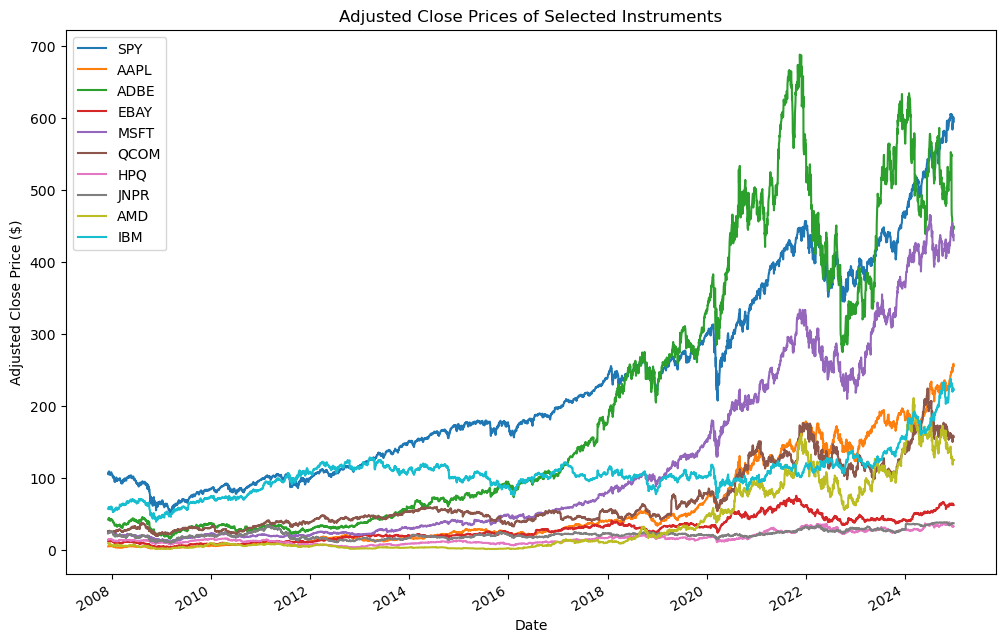

In [5]:
df.plot(figsize=(12,8))
plt.title('Adjusted Close Prices of Selected Instruments')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price ($)')
plt.legend(df.columns)
plt.show()

Lets run our method on the list and see if any pairs are cointegrated.

In [6]:
# Call find_cointegrated_pairs with the DataFrame
def find_cointegrated_pairs(data):
    n = data.shape[1]  # Number of columns (stocks)
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.columns  # Getting the stock tickers
    pairs = []

    # Perform cointegration test for each unique pair of stocks
    for i in range(n):
        for j in range(i + 1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]  # Cointegration test score (test statistic)
            pvalue = result[1]  # p-value of the cointegration test

            # Fill the score and p-value matrices symmetrically
            score_matrix[i, j] = score
            score_matrix[j, i] = score  # Symmetric
            pvalue_matrix[i, j] = pvalue
            pvalue_matrix[j, i] = pvalue  # Symmetric

            # If the p-value is below 0.05, consider this a cointegrated pair
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))

    # Convert score_matrix and pvalue_matrix to DataFrames for easy handling
    score_df = pd.DataFrame(score_matrix, index=keys, columns=keys)
    pvalue_df = pd.DataFrame(pvalue_matrix, index=keys, columns=keys)

    return score_df, pvalue_df, pairs

# Find cointegrated pairs and their p-values
score_df, pvalue_df, pairs = find_cointegrated_pairs(df)


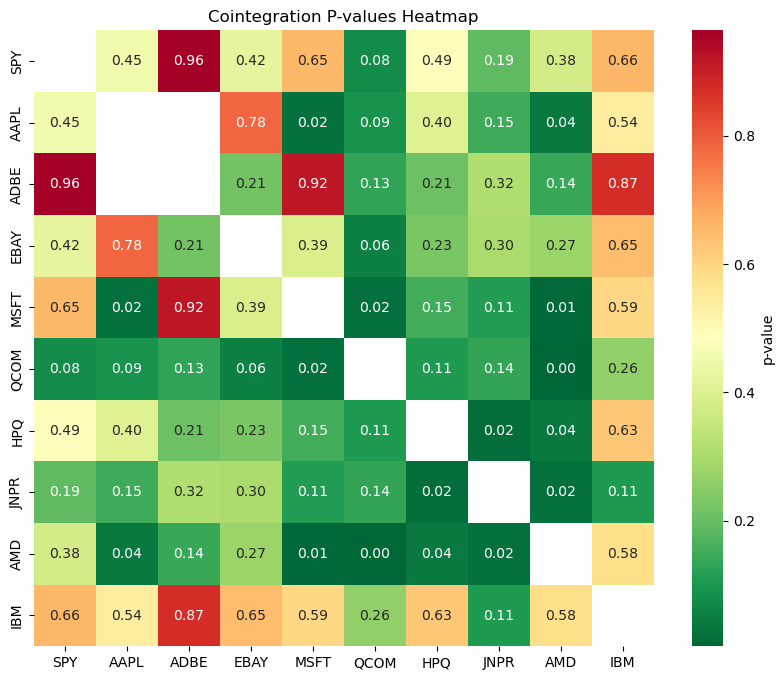

Cointegrated pairs with p-value < 0.05:
[('AAPL', 'MSFT'), ('AAPL', 'AMD'), ('MSFT', 'QCOM'), ('MSFT', 'AMD'), ('QCOM', 'AMD'), ('HPQ', 'JNPR'), ('HPQ', 'AMD'), ('JNPR', 'AMD')]


In [7]:
import seaborn as sns

# Plotting the p-value heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pvalue_df, cmap='RdYlGn_r', annot=True, fmt=".2f", 
            mask=(pvalue_df >= 0.98), cbar_kws={'label': 'p-value'})
plt.title('Cointegration P-values Heatmap')
plt.show()

# Print the cointegrated pairs
print("Cointegrated pairs with p-value < 0.05:")
print(pairs)

Cointegration, very similar to correlation, means that the ratio between two series will vary around a mean. 

The two series, AAPL and MSFT follow the follwing: AAPL = ⍺ MSFT + e where ⍺ is the constant ratio and e is noise.

For pairs trading to work between two timeseries, the expected value of the ratio over time must converge to the mean, i.e. they should be cointegrated.


/Users/zakariyaboutayeb/anaconda3/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/Users/zakariyaboutayeb/anaconda3/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/Users/zakariyaboutayeb/anaconda3/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/Users/zakariyaboutayeb/anaconda3/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in Timedel

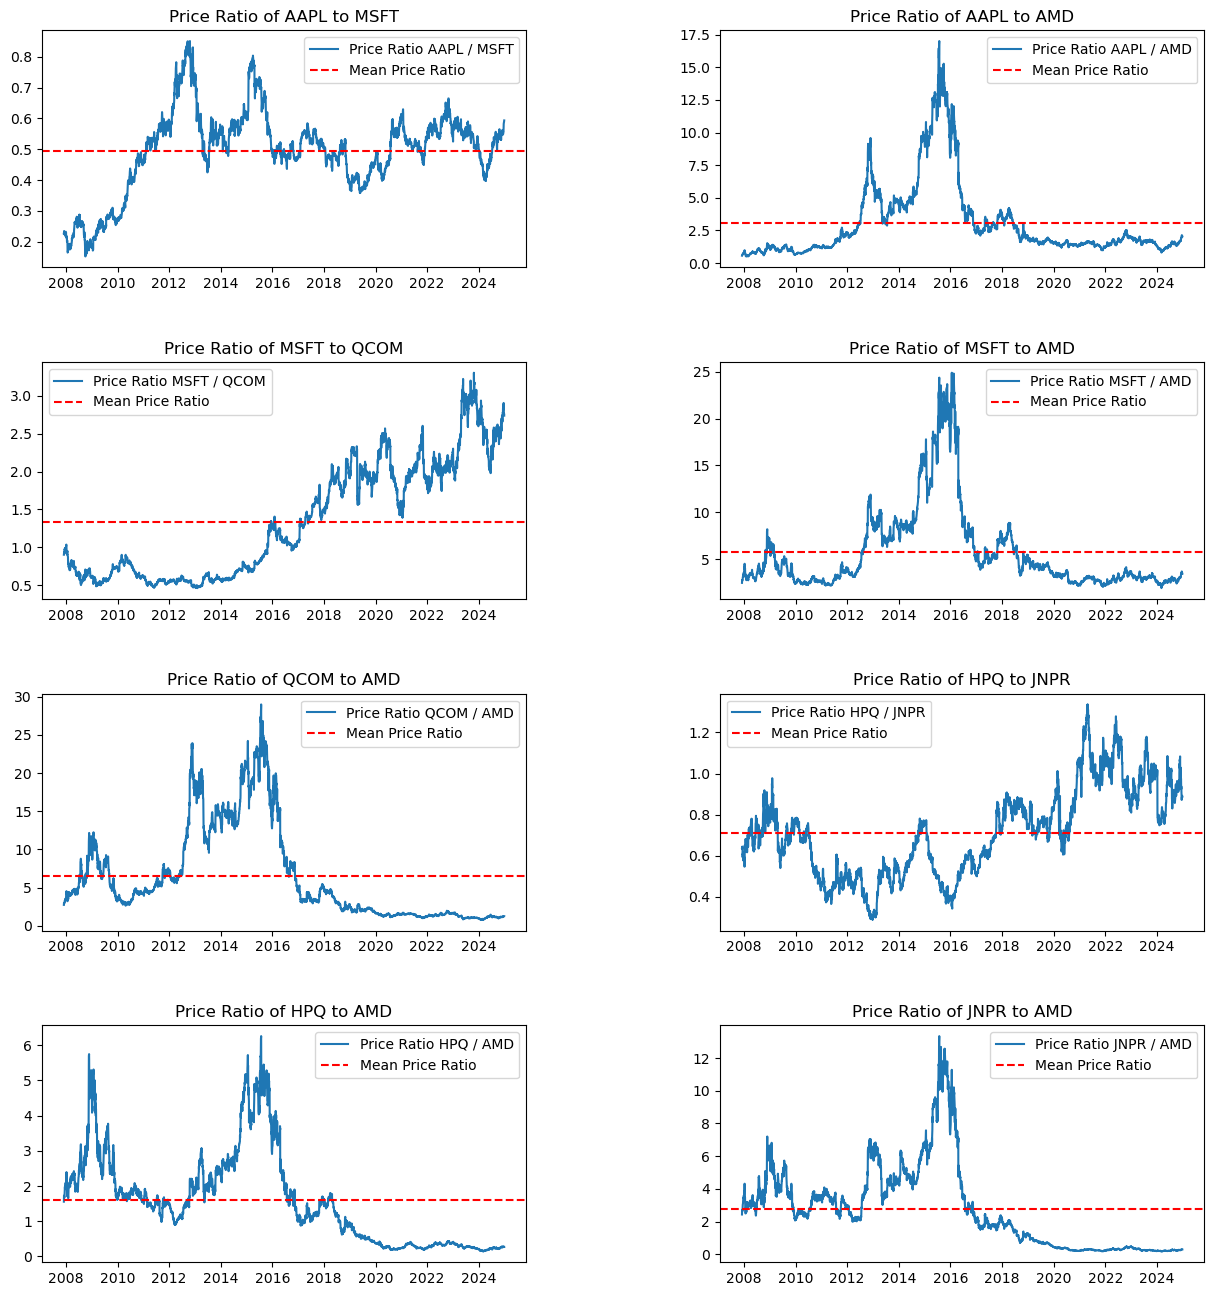

In [8]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint

# List of cointegrated pairs
pairs = [
    ('AAPL', 'MSFT'),
    ('AAPL', 'AMD'),
    ('MSFT', 'QCOM'),
    ('MSFT', 'AMD'),
    ('QCOM', 'AMD'),
    ('HPQ', 'JNPR'),
    ('HPQ', 'AMD'),
    ('JNPR', 'AMD')
]

# Fetch stock data for the relevant tickers
startDate = '2007-12-01'
endDate = '2024-12-30'
symbols = list(set([stock for pair in pairs for stock in pair]))  # Extract all unique stock symbols

# Download data for all the symbols
data = yf.download(symbols, start=startDate, end=endDate)['Adj Close']

# Create a plot for each pair
n_pairs = len(pairs)
rows = (n_pairs // 2)   # Adjust rows to fit 2 plots per row 
fig, axes = plt.subplots(rows, 2, figsize=(15, rows * 4))  # Adjust height based on number of rows

# Flatten axes array for easier iteration (if there are multiple rows/columns)
axes = axes.flatten()

for idx, (stock1, stock2) in enumerate(pairs):
    # Calculate the price ratio for the current pair
    S1 = data[stock1]
    S2 = data[stock2]
    ratios = S1 / S2
    
    # Create a plot for each pair in the respective axis
    axes[idx].plot(ratios, label=f'Price Ratio {stock1} / {stock2}')
    axes[idx].axhline(ratios.mean(), color='red', linestyle='--', label='Mean Price Ratio')
    axes[idx].set_title(f'Price Ratio of {stock1} to {stock2}')
    axes[idx].legend()

# Adjust layout for better spacing
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()


Let's perform a cointegration test between two stocks, AAPL and MSFT, using the coint function from statsmodels to determine if there's a long-term relationship between their prices. 

After running the test, we're calculating the price ratio between the two stocks and plotting it.

0.02464642062042556


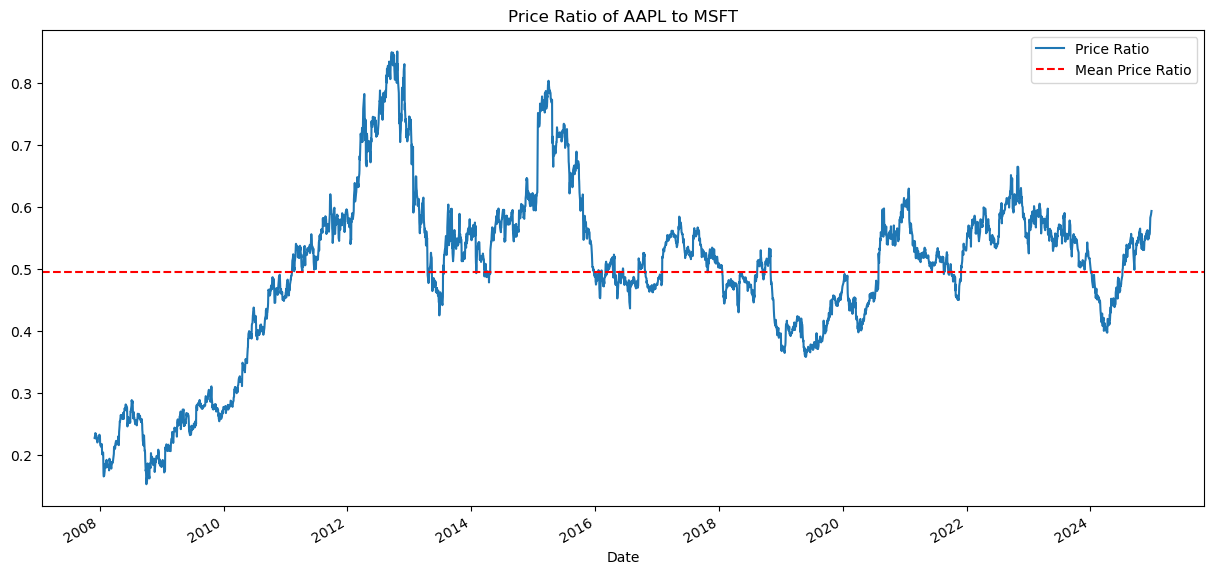

In [9]:
# Fetch stock data for the relevant tickers
startDate = '2007-12-01'
endDate = '2024-12-30'
symbols = list(set([stock for pair in pairs for stock in pair]))  # Extract all unique stock symbols

S1 = data['AAPL']
S2 = data['MSFT']
score, pvalue, _ = coint(S1, S2)
print(pvalue)
ratios = S1 / S2 # Calculate the price ratio of AAPL to MSFT
ratios.plot(figsize=(15,7))
plt.axhline(ratios.mean(), color='red', linestyle='--')
plt.title('Price Ratio of AAPL to MSFT')
plt.legend(['Price Ratio', 'Mean Price Ratio'])
plt.show()

A low p-value (0.0246 < 0.05) indicates that AAPL and MSFT are likely cointegrated, meaning they share a long-term equilibrium relationship, their price series move together over time in a way that allows for a stable relationship. If the p-value is above 0.05, we might conclude that they are not cointegrated.

The ratio does look like it moved around a stable mean.The absolute ratio isn’t very useful in statistical terms. It is more helpful to normalize our signal by treating it as a z-score. Z score is defined as:

Z Score (Value) = (Value — Mean) / Standard Deviation

WARNING In practice this is usually done to try to give some scale to the data, but this assumes an underlying distribution. Usually normal. However, much financial data is not normally distributed, and we must be very careful not to simply assume normality, or any specific distribution when generating statistics. The true distribution of ratios could be very fat-tailed and prone to extreme values messing up our model and resulting in large losses.

In [10]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

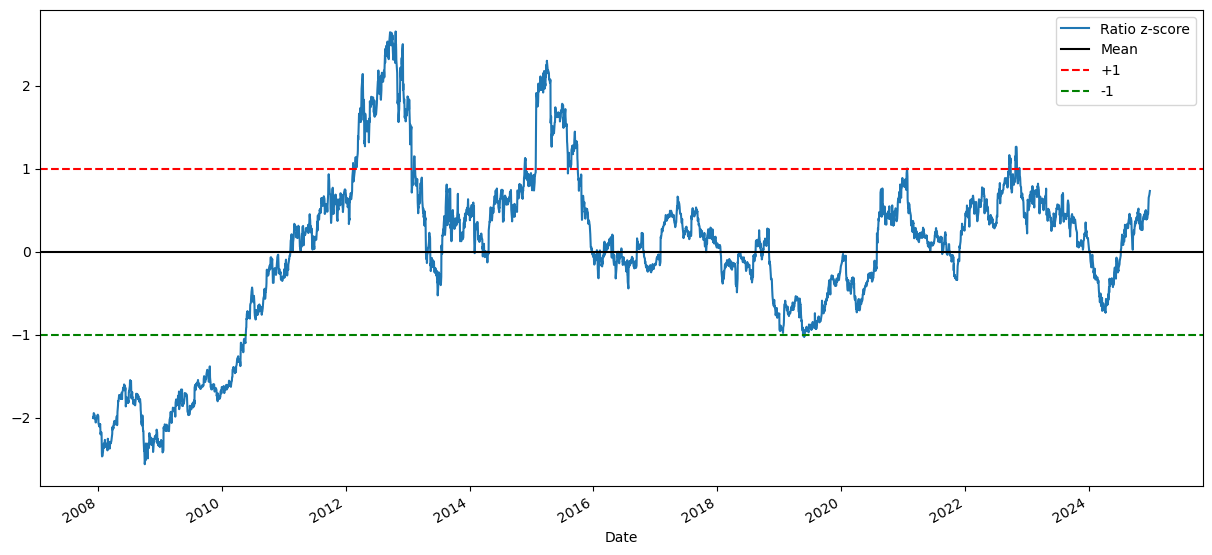

In [11]:
zscore(ratios).plot(figsize=(15,7))
plt.axhline(zscore(ratios).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Ratio z-score', 'Mean', '+1', '-1'])
plt.show()

Simple Strategy:
    
- Go "Long" the ratio whenever the z-score is below -1.0
- Go "Short" the ratio when the z-score is above 1.0
- Exit positions when the z-score approaches zero

This is just the tip of the iceberg, and only a very simplistic example to illustrate the concepts.

- In practice you would want to compute a more optimal weighting for how many shares to hold for S1 and S2
- You would also want to trade using constantly updating statistics.

In general taking a statistic over your whole sample size can be bad. For example, if the market is moving up, and both securities with it, then your average price over the last 3 years may not be representative of today. For this reason traders often use statistics that rely on rolling windows of the most recent data.

Instead of using ratio values, let's use 5d Moving Average to compute to z score, and the 60d Moving Average and 60d Standard Deviation as the mean and standard deviation.

First break the data into training set and test set:

In [12]:
# Total length of ratios
total_length = len(ratios)

# Train and test set lengths
train_len = int(total_length * 0.8)  # 80% for training
test_len = total_length - train_len   # 20% for testing

# Define the training and test sets
train = ratios[:train_len]
test = ratios[train_len:]

# Check the lengths
print(f"Training set length: {len(train)}")
print(f"Test set length: {len(test)}")


Training set length: 3437
Test set length: 860


In [13]:
# Fetch stock data for the relevant tickers
startDate = '2007-12-01'
endDate = '2024-12-30'
symbols = list(set([stock for pair in pairs for stock in pair]))  # Extract all unique stock symbols

ratios = data['AAPL'] / data['MSFT'] # calculates the price ratio of AAPL to MSFT
print(len(ratios)) # prints the total number of data points in the ratios series
train = ratios[:3437]
test = ratios[3437:]

4297


Computes the rolling mean for a window of the 5-day and 60-day moving average. In addition, we compute the rolling standard deviation for a window of 60 days. The standard deviation gives us a measure of volatility.

The Z-score is a standardized measure that tells you how many standard deviations the current value is from the 60-day moving average. It is used to identify overbought or oversold conditions.

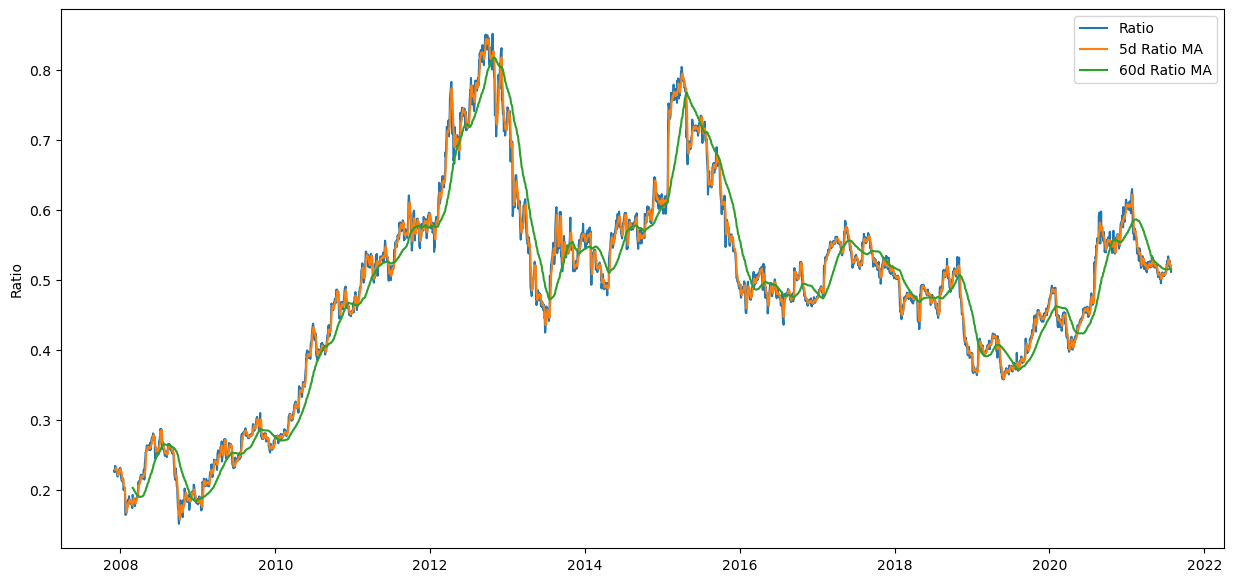

In [14]:
# Rolling Mean for 5-Day MA and 60-Day MA
ratios_mavg5 = train.rolling(window=5, center=False).mean()
ratios_mavg60 = train.rolling(window=60, center=False).mean()

# Rolling Standard Deviation (60-Day)
std_60 = train.rolling(window=60, center=False).std()

# Z-Score Calculation
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60

# plot the raw price ratio (train), the 5-day MA and the 60-day MA over time
plt.figure(figsize=(15,7))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)

plt.legend(['Ratio','5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

We might want to also visualize the Z-score of the 5-day and 60-day ratio to see how the price ratio deviates from the historical mean.

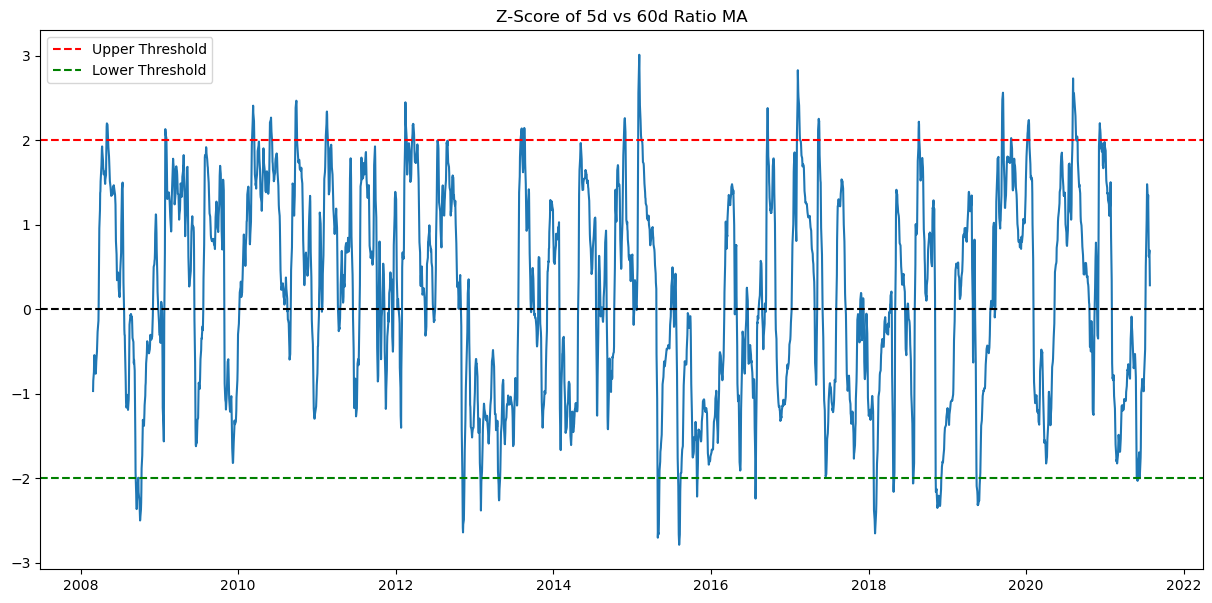

In [15]:
plt.figure(figsize=(15,7))
plt.plot(zscore_60_5.index, zscore_60_5.values)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=2, color='r', linestyle='--', label='Upper Threshold')
plt.axhline(y=-2, color='g', linestyle='--', label='Lower Threshold')
plt.title('Z-Score of 5d vs 60d Ratio MA')
plt.legend()
plt.show()


The z-score doesn't mean much out of context, let's plot it next to the prices to get an idea of what it looks like.

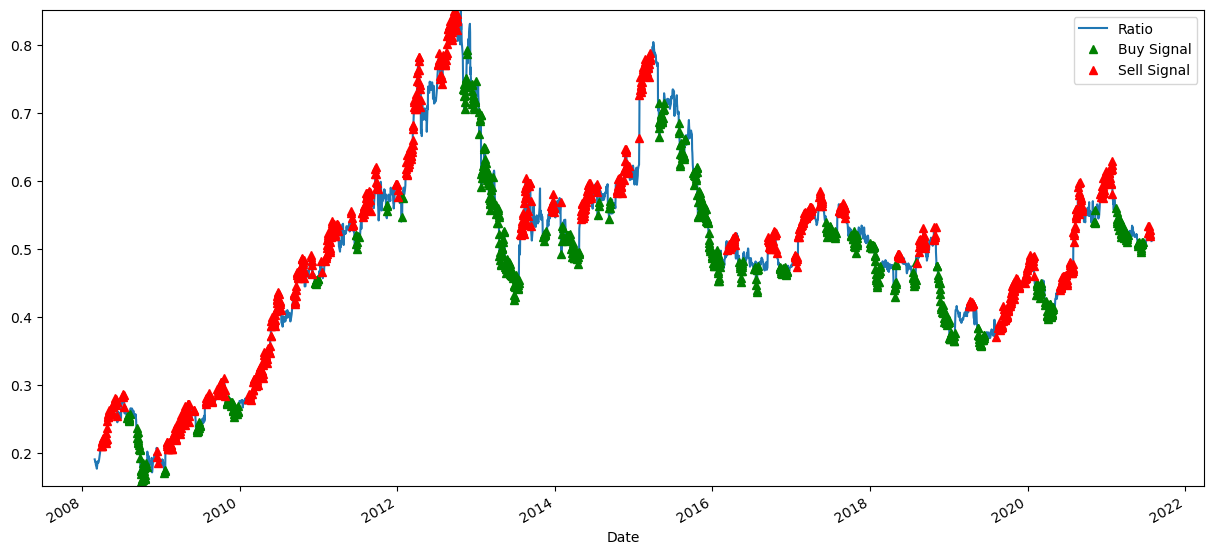

In [16]:
# Plot the ratios and buy and sell signals from z score
plt.figure(figsize=(15,7))

train[60:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[60:].plot(color='g', linestyle='None', marker='^')
sell[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratios.min(),ratios.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

Our goal is to plot the stock prices for AAPL and MSFT, and show the buy and sell signals on the chart based on the z-score of the price ratio: Buy when the Z-score is below a certain threshold and selling when it is above.

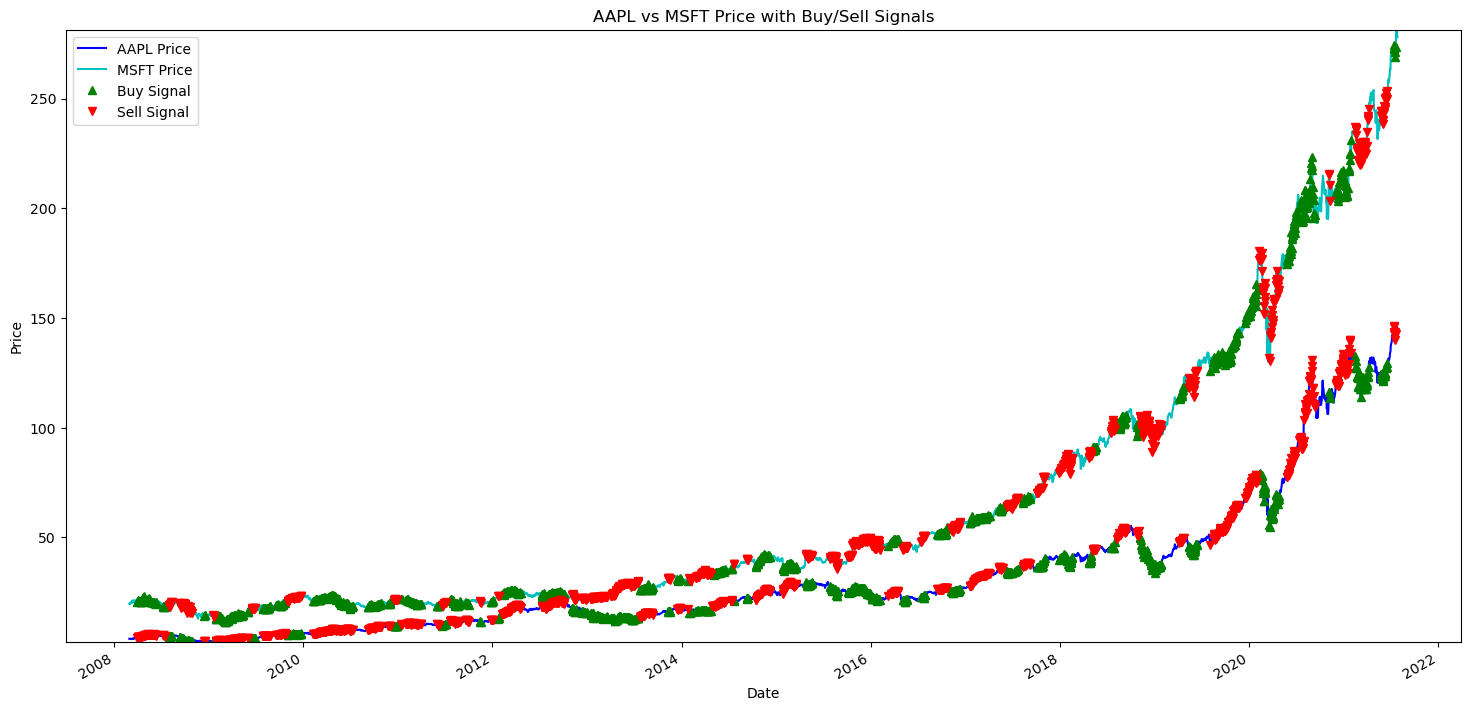

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming data is already loaded
S1 = data['AAPL'].iloc[:3437]  # AAPL prices
S2 = data['MSFT'].iloc[:3437]  # MSFT prices

# Calculate the price ratio and moving averages for Z-score calculation
ratio = S1 / S2
mavg5 = ratio.rolling(window=5).mean()  # 5-day moving average of the ratio
mavg60 = ratio.rolling(window=60).mean()  # 60-day moving average of the ratio
std_60 = ratio.rolling(window=60).std()  # 60-day rolling standard deviation

# Z-score calculation
zscore = (mavg5 - mavg60) / std_60

# Define the thresholds for the Z-score (e.g., Z-score > 1 for sell, Z-score < -1 for buy)
buy = (zscore < -1).astype(int)  # Buy signal when Z-score is below -1
sell = (zscore > 1).astype(int)  # Sell signal when Z-score is above 1

# Create the buy and sell signals for plotting
buyR = 0 * S1.copy()  # Initialize buy signal array
sellR = 0 * S1.copy()  # Initialize sell signal array

# When buying the ratio, buy S1 and sell S2
buyR[buy != 0] = S1[buy != 0]
sellR[buy != 0] = S2[buy != 0]

# When selling the ratio, sell S1 and buy S2
buyR[sell != 0] = S2[sell != 0]
sellR[sell != 0] = S1[sell != 0]

# Plotting the prices and the buy/sell signals
plt.figure(figsize=(18, 9))

# Plot the stock prices
S1[60:].plot(color='b', label='AAPL Price')
S2[60:].plot(color='c', label='MSFT Price')

# Plot the buy and sell signals
buyR[60:].plot(color='g', linestyle='None', marker='^', label='Buy Signal')
sellR[60:].plot(color='r', linestyle='None', marker='v', label='Sell Signal')

# Adjust the axis to fit the data
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))

# Add labels and legends
plt.title('AAPL vs MSFT Price with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Show the plot
plt.show()


Buy and Sell Signals:
- A buy signal is triggered when the Z-score is below -1 (indicating the ratio is significantly lower than its historical average).
- A sell signal is triggered when the Z-score is above 1 (indicating the ratio is significantly higher than its historical average).

Buy/Sell Actions:
- When a buy signal occurs, AAPL is bought and MSFT is sold (and vice versa for the sell signal).
- The respective prices are then marked on the plot using green upward arrows (^) for buy signals and red downward arrows (v) for sell signals.

Notice how we sometimes make money on the short leg and sometimes on the long leg, and sometimes both.

Let’s see what kind of profits this signal can generate. We write a simple backtester which buys 1 ratio (buy 1 AAPL stock and sell ratio x MSFT stock) when ratio is low, sell 1 ratio (sell 1 AAPL stock and buy ratio x MSFT stock) when it’s high and calculate PnL of these trades.

- Buy: You enter a long position (buy AAPL and short MSFT) when the z-score is less than -1.
- Sell: You enter a short position (short AAPL and buy MSFT) when the z-score is greater than 1.
- Close positions: You close the positions when the z-score is between -0.5 and 0.5.

In [18]:
def trade(S1, S2, window1, window2, initial_capital=100000):
    if (window1 == 0) or (window2 == 0):
        return 0

    ratios = S1 / S2
    ma1 = ratios.rolling(window=window1, center=False).mean()
    ma2 = ratios.rolling(window=window2, center=False).mean()
    std = ratios.rolling(window=window2, center=False).std()
    zscore = (ma1 - ma2) / std

    money = initial_capital  # Start with initial capital
    countS1 = 0
    countS2 = 0

    for i in range(1, len(ratios)):
        if zscore[i] > 1:  # Short S1, buy S2
            money -= S1[i]
            money += S2[i]
            countS1 -= 1
            countS2 += 1
        elif zscore[i] < -1:  # Buy S1, short S2
            money += S1[i]
            money -= S2[i]
            countS1 += 1
            countS2 -= 1
        elif abs(zscore[i]) < 0.5:  # Close positions
            money += countS1 * S1[i]
            money -= countS2 * S2[i]
            countS1 = 0
            countS2 = 0

    # Final liquidation
    money += countS1 * S1.iloc[-1]
    money -= countS2 * S2.iloc[-1]

    return money

# Test the function with sample data and initial capital
result = trade(data['AAPL'].iloc[:3437], data['MSFT'].iloc[:3437], window1=5, window2=60, initial_capital=100000)
print(f"Final portfolio value: {result}")


Final portfolio value: 78618.00748515129


/var/folders/c4/xntd0yb16dz1d4dv_zrhdtvc0000gn/T/ipykernel_2442/4215101753.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if zscore[i] > 1:  # Short S1, buy S2
/var/folders/c4/xntd0yb16dz1d4dv_zrhdtvc0000gn/T/ipykernel_2442/4215101753.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif zscore[i] < -1:  # Buy S1, short S2
/var/folders/c4/xntd0yb16dz1d4dv_zrhdtvc0000gn/T/ipykernel_2442/4215101753.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posit

This means the strategy has increased the portfolio value from the initial capital of usd 0.00  to  usd 78,618 during the backtest period.

Now we can optimize further by changing our moving average windows, by changing the thresholds for buy/sell and exit positions etc and check for performance improvements on validation data. We could also try more sophisticated models like Logistic Regression, SVM etc to make our 1/-1 predictions.

In [19]:
# Test the function with sample data and initial capital
result = trade(data['AAPL'].iloc[:3437], data['MSFT'].iloc[:3437], window1=5, window2=90, initial_capital=100000)
print(f"Final portfolio value: {result}")

Final portfolio value: 81729.17213392258


/var/folders/c4/xntd0yb16dz1d4dv_zrhdtvc0000gn/T/ipykernel_2442/4215101753.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if zscore[i] > 1:  # Short S1, buy S2
/var/folders/c4/xntd0yb16dz1d4dv_zrhdtvc0000gn/T/ipykernel_2442/4215101753.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif zscore[i] < -1:  # Buy S1, short S2
/var/folders/c4/xntd0yb16dz1d4dv_zrhdtvc0000gn/T/ipykernel_2442/4215101753.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posit

The strategy seems profitable again over different time periods and it consistently performs well.

### Avoid Overfitting

Overfitting is the most dangerous pitfall of a trading strategy. In our model, we used rolling parameter estimates and may wish to optimize window length that gives the highest returns based on the strategy. 

In [33]:
# Define a function to find the optimal window length that maximizes returns
def find_best_window_length(data, start_idx, end_idx, max_window=254):
    length_scores = []
    for l in range(1, max_window + 1):  # Start from 1 to avoid division by zero
        score = trade(data['AAPL'].iloc[0:3437], 
                      data['MSFT'].iloc[0:3437], window1=5, window2=l)
        length_scores.append(score)
    
    best_length = np.argmax(length_scores) + 1  # Best window length (1-based index)
    best_score = length_scores[best_length - 1]  # Get the corresponding score
    return best_length, best_score

# Find the best window length between 0-254
best_length, best_score = find_best_window_length(data, 0, 3437)
print(f"Best window length: {best_length}")
print(f"Best score: {best_score}")


/var/folders/c4/xntd0yb16dz1d4dv_zrhdtvc0000gn/T/ipykernel_2442/4215101753.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if zscore[i] > 1:  # Short S1, buy S2
/var/folders/c4/xntd0yb16dz1d4dv_zrhdtvc0000gn/T/ipykernel_2442/4215101753.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif zscore[i] < -1:  # Buy S1, short S2
/var/folders/c4/xntd0yb16dz1d4dv_zrhdtvc0000gn/T/ipykernel_2442/4215101753.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posit

Best window length: 2
Best score: 103473.99542570114


Now we check the performance of our model on test data and identifying the best window length based on it. This is because our original choice was clearly overfitted to the sample data.

In [34]:
# Find returns for test data using the best window length from training
length_scores2 = [trade(data['AAPL'].iloc[3437:], 
                        data['MSFT'].iloc[3437:], 5, l) 
                  for l in range(1, 255)]  # Start from 1 to match the window length

# Print the score for the best window length from training (1-based index)
print(f"Best length from training: {best_length} day window: {length_scores2[best_length - 1]}")

# Now find the best window length based on the test data
best_length2 = np.argmax(length_scores2) + 1  # Convert to 1-based index
print(f"Best window length on test data: {best_length2} day window: {length_scores2[best_length2 - 1]}")


/var/folders/c4/xntd0yb16dz1d4dv_zrhdtvc0000gn/T/ipykernel_2442/4215101753.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if zscore[i] > 1:  # Short S1, buy S2
/var/folders/c4/xntd0yb16dz1d4dv_zrhdtvc0000gn/T/ipykernel_2442/4215101753.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif zscore[i] < -1:  # Buy S1, short S2
/var/folders/c4/xntd0yb16dz1d4dv_zrhdtvc0000gn/T/ipykernel_2442/4215101753.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posit

Best length from training: 2 day window: 106841.80558776855
Best window length on test data: 254 day window: 129808.76487731934


Training vs Test Results: 

The best window length based on the training data is 2 days, and the corresponding score is 103,474. But when you apply the best window length to the test data, the best score corresponds to a 254-day window, with a much higher score of 129,809.

Overfitting: 

The difference between the best window lengths and scores on the training vs. test data could indicate that the strategy is fitting too closely to the training set (i.e., overfitting). A larger window length on the test data may lead to artificially higher scores if the model is "memorizing" patterns that don't generalize well.

We can see this if we also plot Pnl by window length separately for traning and test data

/var/folders/c4/xntd0yb16dz1d4dv_zrhdtvc0000gn/T/ipykernel_2442/4215101753.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if zscore[i] > 1:  # Short S1, buy S2
/var/folders/c4/xntd0yb16dz1d4dv_zrhdtvc0000gn/T/ipykernel_2442/4215101753.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif zscore[i] < -1:  # Buy S1, short S2
/var/folders/c4/xntd0yb16dz1d4dv_zrhdtvc0000gn/T/ipykernel_2442/4215101753.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posit

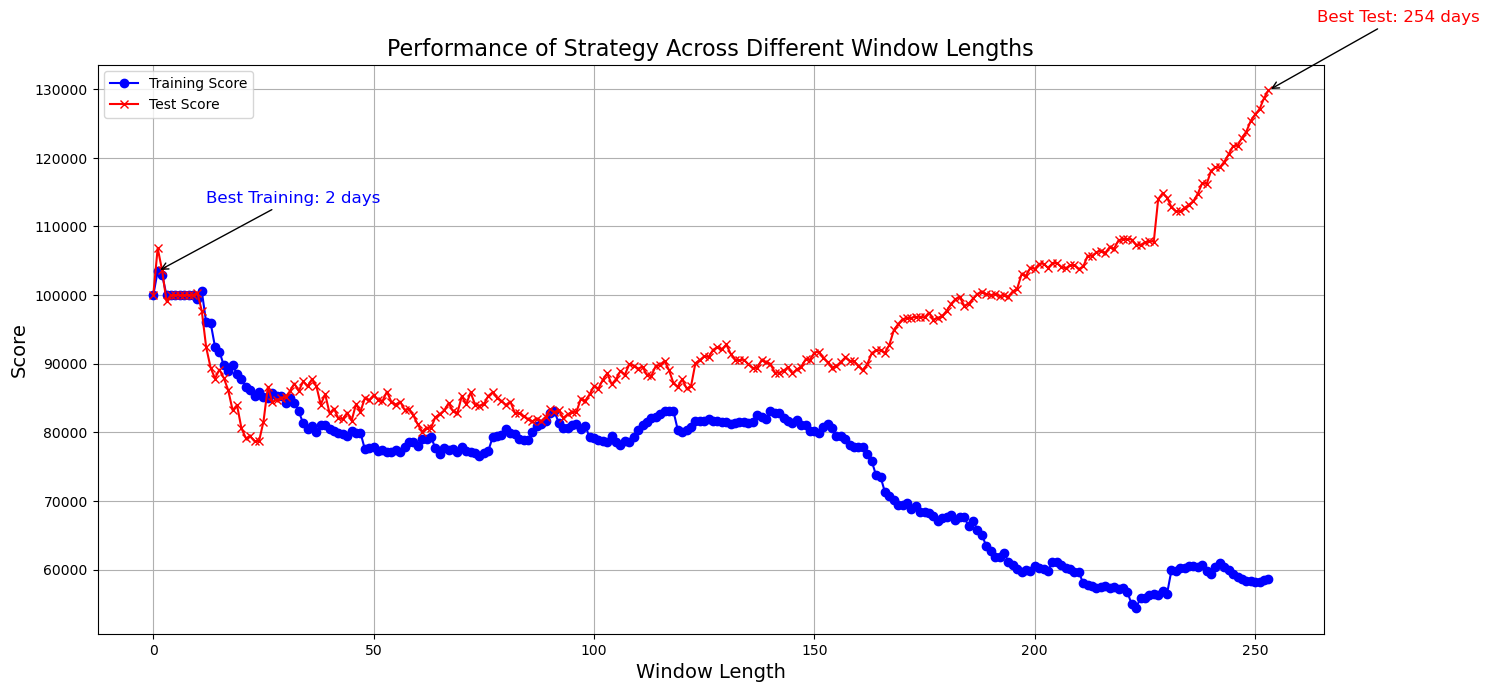

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the 'trade' function and your data 'data' are already defined
# Let's define the length_scores and length_scores2

# Calculate the training scores using the training portion of the data
length_scores = [trade(data['AAPL'].iloc[0:3437],  # Replace with actual training data indices
                        data['MSFT'].iloc[0:3437], 5, l)
                 for l in range(1, 255)]  # Adjust the window range as needed

# Calculate the test scores using the test portion of the data
length_scores2 = [trade(data['AAPL'].iloc[3437:],  # Replace with actual test data indices
                         data['MSFT'].iloc[3437:], 5, l)
                  for l in range(1, 255)]  # Adjust the window range as needed

# Find the best window lengths based on training and test data
best_length = np.argmax(length_scores) + 1  # Best window length for training data (1-based)
best_length2 = np.argmax(length_scores2) + 1  # Best window length for test data (1-based)

# Plot the training and test scores for different window lengths
plt.figure(figsize=(15, 7))
plt.plot(length_scores, label='Training Score', color='blue', marker='o')
plt.plot(length_scores2, label='Test Score', color='red', marker='x')

# Annotating the best window lengths
plt.annotate(f'Best Training: {best_length} days', 
             xy=(best_length-1, length_scores[best_length-1]), 
             xytext=(best_length+10, length_scores[best_length-1] + 10000),
             arrowprops=dict(facecolor='blue', arrowstyle='->'),
             fontsize=12, color='blue')

plt.annotate(f'Best Test: {best_length2} days', 
             xy=(best_length2-1, length_scores2[best_length2-1]), 
             xytext=(best_length2+10, length_scores2[best_length2-1] + 10000),
             arrowprops=dict(facecolor='red', arrowstyle='->'),
             fontsize=12, color='red')

# Labels and Title
plt.xlabel('Window Length', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.title('Performance of Strategy Across Different Window Lengths', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()  # Ensures that labels are not clipped
plt.show()


The plot will show two curves:
- Training Curve: Shows how the model performs on the training data for different window lengths.
- Test Curve: Shows how the model performs on the test data for different window lengths.

By comparing the two, you can assess whether the strategy is overfitting to the training data (i.e., if the training curve performs significantly better than the test curve).

The pair trading strategy prediction model successfully identifies cointegrated pairs, generates trading signals, and demonstrates profitability through backtesting. By avoiding overfitting and optimizing parameters, the strategy can be further refined for real-world trading.